# IMPORTS

## Libraries

In [1]:
import warnings

import numpy  as np
import pandas as pd

import seaborn           as sns
import matplotlib.pyplot as plt

from scipy import stats as ss

from IPython.display      import Image
from IPython.core.display import HTML

# data balancing
from imblearn.combine        import SMOTETomek
# feature selection
from boruta                  import BorutaPy
from skopt                   import forest_minimize
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from sklearn.metrics         import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Load Dataset

In [2]:
dfRawTrain = pd.read_feather('00-Data/FeatherData/trainDatasetScaling.feather')

## Helper Functions

#### Jupyter Settings

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    seed = 0
    np.random.seed(seed)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [4]:
jupyter_settings()  

Populating the interactive namespace from numpy and matplotlib


#### Functions

In [5]:
def mlScores(modelName, y, yhat, yhatProba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    ap = average_precision_score(y, yhatProba)
    rocauc = roc_auc_score(y, yhatProba)
    
    return pd.DataFrame({ 'Model Name': modelName, 
                           'Precision': precision, 
                           'Recall': recall,
                           'F1 Score': f1,
                           'Kappa': kappa,
                           'Average Precision Score': ap,
                           'ROC AUC': rocauc}, index=[0])



def crossValidation(XTraining, kfold, modelName, model, verbose=False):
    precisionList = []
    recallList = []
    f1List = []
    kappaList = []
    apList = []
    rocaucList = []
    XTraining = XTraining.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # Filtering Dataset
        training = XTraining.iloc[0: k*(round(XTraining.shape[0]/(kfold+1))), :]
        validation = XTraining.iloc[k*(round(XTraining.shape[0]/(kfold+1))) : (k+1)*(round(XTraining.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        XKFoldTraining = training.drop(['Exited'], axis=1)
        yKFoldTraining = training['Exited']

        # Validation
        XKFoldValidation = validation.drop(['Exited'], axis=1)
        yKFoldValidation = validation['Exited']
        
        # set the resampler
#         resampler = SMOTETomek(random_state=42, n_jobs=-1)
#         # resample the dataset
#         XKFoldTrainingBalanced, yKFoldTrainingBalanced = resampler.fit_resample(XKFoldTraining, yKFoldTraining)
#         XKFoldValidationBalanced = XKFoldValidation
#         yKFoldValidationBalanced = yKFoldValidation
        #XKFoldValidationBalanced, yKFoldValidationBalanced = resampler.fit_resample(XKFoldValidation, yKFoldValidation)
        
        #Model
        model.fit(XKFoldTraining, yKFoldTraining)

        # Prediction
        yhat = model.predict(XKFoldValidation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(XKFoldValidation)[:,1]

        #Performance
        modelResult = mlScores(modelName, yKFoldValidation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precisionList.append(modelResult['Precision'].tolist())
        recallList.append(modelResult['Recall'].tolist())
        f1List.append(modelResult['F1 Score'].tolist())
        kappaList.append(modelResult['Kappa'].tolist())
        apList.append(modelResult['Average Precision Score'].tolist())
        rocaucList.append(modelResult['ROC AUC'].tolist())
    

    dictResult = {
                    'Model Name': [modelName],
                    'Precision CV': [np.round(np.mean(precisionList),2).astype(str) + ' +/- ' + np.round(np.std(precisionList),2).astype(str)],
                    'Recall CV': [np.round(np.mean(recallList),2).astype(str) + ' +/- ' + np.round(np.std(recallList),2).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1List),2).astype(str) + ' +/- ' + np.round(np.std(f1List),2).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappaList),2).astype(str) + ' +/- ' + np.round(np.std(kappaList),2).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(apList),2).astype(str) + ' +/- ' + np.round(np.std(apList),2).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(rocaucList),2).astype(str) + ' +/- ' + np.round(np.std(rocaucList),2).astype(str)]
                }

    return pd.DataFrame(dictResult)

# Modelling

In [6]:
df07 = dfRawTrain.copy()

In [7]:
colsSelectedBoruta = ['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'AgeGroup_Midlife']

## X,y Split

In [8]:
# Train
yTrain = df07['Exited']
XTrain = df07[colsSelectedBoruta]

# set the resampler
resampler = SMOTETomek(random_state=42, n_jobs=-1)
# resample the dataset
XBalanced, yBalanced = resampler.fit_resample(XTrain, yTrain)

dfTrain = pd.concat([XBalanced, yBalanced], axis=1)

## Data Balancing

Text(0.5, 1.0, 'After SMOTE')

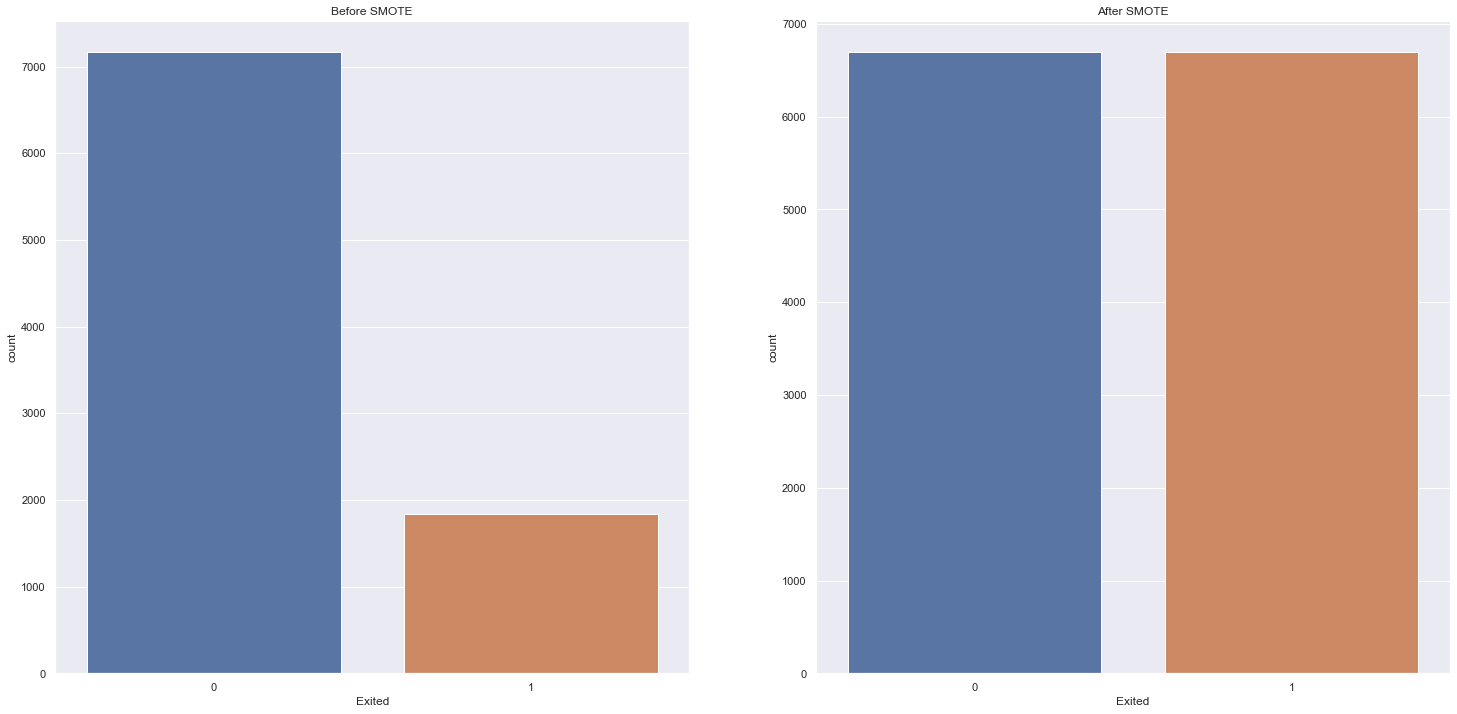

In [9]:
# plots before and after SMOTE
plt.subplot(1,2,1)
sns.countplot(x=yTrain);
plt.title("Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=yBalanced);
plt.title("After SMOTE")

# MODELS
---
- Lightgbm Classifier
- Random Forest Classifier
- XGBoost Classifier

In [48]:
dfResultsLGBM = pd.DataFrame()
dfResultsRF = pd.DataFrame()
dfResultsXGB = pd.DataFrame()

## Lightgbm Classifier

In [49]:
def tuneLGBM(params):
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    
    dictParams = {'learning_rate': lr,
                 'max_depth': max_depth,
                 'min_child_samples': min_child_samples,
                 'subsample': subsample,
                 'colsample_bytree': colsample_bytree,
                 'n_estimators': n_estimators}
    
    modelName = 'Lightgbm Classifier'
    kfold = 10
    
    precisionList = []
    recallList = []
    f1List = []
    kappaList = []
    apList = []
    rocaucList = []
    paramList =[]
    XTraining = dfTrain.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = XTraining.iloc[0: k*(round(XTraining.shape[0]/(kfold+1))), :]
        validation = XTraining.iloc[k*(round(XTraining.shape[0]/(kfold+1))) : (k+1)*(round(XTraining.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        XKFoldTraining = training.drop(['Exited'], axis=1)
        yKFoldTraining = training['Exited']

        # Validation
        XKFoldValidation = validation.drop(['Exited'], axis=1)
        yKFoldValidation = validation['Exited']
        
        
    
        model = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                               min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree,
                               bagging_freq=1, n_estimators=n_estimators, random_state=0, class_weight='balanced', n_jobs=-1)
    
    
        #Model
        model.fit(XKFoldTraining, yKFoldTraining)
    
           # Prediction
        yhat = model.predict(XKFoldValidation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(XKFoldValidation)[:,1]
                #Performance
        modelResult = mlScores(modelName, yKFoldValidation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precisionList.append(modelResult['Precision'].tolist())
        recallList.append(modelResult['Recall'].tolist())
        f1List.append(modelResult['F1 Score'].tolist())
        kappaList.append(modelResult['Kappa'].tolist())
        apList.append(modelResult['Average Precision Score'].tolist())
        rocaucList.append(modelResult['ROC AUC'].tolist())
        paramList.append(dictParams)
    

    dictResult = {
                    'Model Name': [modelName],
                    'Precision CV': [np.round(np.mean(precisionList),4).astype(str) + ' +/- ' + np.round(np.std(precisionList),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recallList),4).astype(str) + ' +/- ' + np.round(np.std(recallList),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1List),4).astype(str) + ' +/- ' + np.round(np.std(f1List),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappaList),4).astype(str) + ' +/- ' + np.round(np.std(kappaList),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(apList),4).astype(str) + ' +/- ' + np.round(np.std(apList),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(rocaucList),4).astype(str) + ' +/- ' + np.round(np.std(rocaucList),4).astype(str)],
                    'Params': [paramList]
                }

    
    dfmetrics = pd.DataFrame(dictResult)
    global dfResultsLGBM
    dfResultsLGBM = pd.concat([dfmetrics, dfResultsLGBM], axis=0)
    
    return -np.mean(apList)

space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1200)] #n_estimetors



result = forest_minimize(tuneLGBM, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

In [50]:
resultLGBM = result.x
resultLGBM

[0.016490254525097375, 9, 9, 0.6502182010234373, 0.6866210554187129, 1069]

In [51]:
dfResultsLGBM.head(20)

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,0.8134 +/- 0.0183,0.7987 +/- 0.0219,0.8058 +/- 0.0169,0.6146 +/- 0.0289,0.8778 +/- 0.0123,0.8799 +/- 0.0103,"[{'learning_rate': 0.018353598126553926, 'max_..."
0,Lightgbm Classifier,0.8724 +/- 0.0257,0.8214 +/- 0.0203,0.8461 +/- 0.022,0.7003 +/- 0.0467,0.9371 +/- 0.0173,0.9217 +/- 0.0208,"[{'learning_rate': 0.07698616486747904, 'max_d..."
0,Lightgbm Classifier,0.8359 +/- 0.0233,0.8001 +/- 0.0288,0.8175 +/- 0.0252,0.6442 +/- 0.048,0.8943 +/- 0.014,0.897 +/- 0.0154,"[{'learning_rate': 0.005545743892663144, 'max_..."
0,Lightgbm Classifier,0.7917 +/- 0.0194,0.7511 +/- 0.0162,0.7707 +/- 0.0126,0.5521 +/- 0.0184,0.8606 +/- 0.0127,0.8588 +/- 0.0076,"[{'learning_rate': 0.017293945600511968, 'max_..."
0,Lightgbm Classifier,0.8702 +/- 0.0241,0.8436 +/- 0.0301,0.8566 +/- 0.0253,0.7172 +/- 0.0494,0.9386 +/- 0.0206,0.9345 +/- 0.0197,"[{'learning_rate': 0.07153671917186938, 'max_d..."
0,Lightgbm Classifier,0.839 +/- 0.0253,0.825 +/- 0.0164,0.8318 +/- 0.0185,0.666 +/- 0.0424,0.9064 +/- 0.0172,0.9066 +/- 0.0172,"[{'learning_rate': 0.028323043345821718, 'max_..."
0,Lightgbm Classifier,0.8736 +/- 0.025,0.8184 +/- 0.0185,0.845 +/- 0.0199,0.7005 +/- 0.0431,0.9355 +/- 0.0195,0.9233 +/- 0.0217,"[{'learning_rate': 0.041299973169667735, 'max_..."
0,Lightgbm Classifier,0.8516 +/- 0.0165,0.8201 +/- 0.0189,0.8354 +/- 0.0156,0.6766 +/- 0.0299,0.9139 +/- 0.0149,0.9133 +/- 0.0147,"[{'learning_rate': 0.01028491314690704, 'max_d..."
0,Lightgbm Classifier,0.8381 +/- 0.0345,0.807 +/- 0.0229,0.8222 +/- 0.0278,0.6504 +/- 0.0555,0.9029 +/- 0.0221,0.9017 +/- 0.0208,"[{'learning_rate': 0.0010815024957285871, 'max..."
0,Lightgbm Classifier,0.8326 +/- 0.0189,0.8128 +/- 0.0238,0.8224 +/- 0.0172,0.6487 +/- 0.0382,0.8977 +/- 0.0112,0.8976 +/- 0.013,"[{'learning_rate': 0.00254165132488824, 'max_d..."


## Random Forest Classifier

In [52]:
def tuneRF(params):
    print(params)
    max_depth = params[0]
    min_samples_leaf = params[1]
    n_estimators = params[2]
    
    dictParams = {'max_depth': max_depth,
                  'min_samples_leaf': min_samples_leaf,
                  'n_estimators': n_estimators}
    
    
    modelName = 'Random Forest Classifier'
    kfold = 10
    
    precisionList = []
    recallList = []
    f1List = []
    kappaList = []
    apList = []
    rocaucList = []
    paramList =[]
    XTraining = dfTrain.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = XTraining.iloc[0: k*(round(XTraining.shape[0]/(kfold+1))), :]
        validation = XTraining.iloc[k*(round(XTraining.shape[0]/(kfold+1))) : (k+1)*(round(XTraining.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        XKFoldTraining = training.drop(['Exited'], axis=1)
        yKFoldTraining = training['Exited']

        # Validation
        XKFoldValidation = validation.drop(['Exited'], axis=1)
        yKFoldValidation = validation['Exited']
        
        
        #Model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=0,
                                           class_weight='balanced', n_jobs=-1)
    
    
        
        model.fit(XKFoldTraining, yKFoldTraining)
    
           # Prediction
        yhat = model.predict(XKFoldValidation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(XKFoldValidation)[:,1]
                #Performance
        modelResult = mlScores(modelName, yKFoldValidation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precisionList.append(modelResult['Precision'].tolist())
        recallList.append(modelResult['Recall'].tolist())
        f1List.append(modelResult['F1 Score'].tolist())
        kappaList.append(modelResult['Kappa'].tolist())
        apList.append(modelResult['Average Precision Score'].tolist())
        rocaucList.append(modelResult['ROC AUC'].tolist())
        paramList.append(dictParams)

    dictResult = {
                    'Model Name': [modelName],
                    'Precision CV': [np.round(np.mean(precisionList),2).astype(str) + ' +/- ' + np.round(np.std(precisionList),2).astype(str)],
                    'Recall CV': [np.round(np.mean(recallList),2).astype(str) + ' +/- ' + np.round(np.std(recallList),2).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1List),2).astype(str) + ' +/- ' + np.round(np.std(f1List),2).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappaList),2).astype(str) + ' +/- ' + np.round(np.std(kappaList),2).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(apList),2).astype(str) + ' +/- ' + np.round(np.std(apList),2).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(rocaucList),2).astype(str) + ' +/- ' + np.round(np.std(rocaucList),2).astype(str)],
                    'Params': [paramList]
                }

    
    dfmetrics = pd.DataFrame(dictResult)
    global dfResultsRF
    dfResultsRF = pd.concat([dfmetrics, dfResultsRF], axis=0)
    
    return -np.mean(apList)

space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1200)] #n_estimetors



result = forest_minimize(tuneRF, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 1064]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 76.5887
Function value obtained: -0.8648
Current minimum: -0.8648
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 17.5262
Function value obtained: -0.7981
Current minimum: -0.8648
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 22.2765
Function value obtained: -0.8906
Current minimum: -0.8906
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 1006]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 65.6767
Function value obtained: -0.7824
Current minimum: -0.8906
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 1134]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 78.0994
Function valu

In [53]:
resultRF = result.x
resultRF

[10, 1, 1050]

In [54]:
dfResultsRF.head(20)

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV,Params
0,Random Forest Classifier,0.81 +/- 0.03,0.76 +/- 0.02,0.78 +/- 0.01,0.58 +/- 0.03,0.88 +/- 0.02,0.88 +/- 0.02,"[{'max_depth': 7, 'min_samples_leaf': 15, 'n_e..."
0,Random Forest Classifier,0.83 +/- 0.02,0.81 +/- 0.02,0.82 +/- 0.02,0.65 +/- 0.03,0.9 +/- 0.02,0.9 +/- 0.01,"[{'max_depth': 10, 'min_samples_leaf': 1, 'n_e..."
0,Random Forest Classifier,0.81 +/- 0.02,0.74 +/- 0.02,0.77 +/- 0.02,0.56 +/- 0.03,0.87 +/- 0.02,0.87 +/- 0.01,"[{'max_depth': 5, 'min_samples_leaf': 14, 'n_e..."
0,Random Forest Classifier,0.79 +/- 0.03,0.72 +/- 0.02,0.76 +/- 0.01,0.53 +/- 0.02,0.86 +/- 0.02,0.86 +/- 0.01,"[{'max_depth': 4, 'min_samples_leaf': 15, 'n_e..."
0,Random Forest Classifier,0.83 +/- 0.01,0.8 +/- 0.03,0.81 +/- 0.02,0.63 +/- 0.04,0.89 +/- 0.01,0.9 +/- 0.01,"[{'max_depth': 10, 'min_samples_leaf': 5, 'n_e..."
0,Random Forest Classifier,0.82 +/- 0.03,0.79 +/- 0.03,0.8 +/- 0.02,0.61 +/- 0.05,0.88 +/- 0.02,0.88 +/- 0.02,"[{'max_depth': 10, 'min_samples_leaf': 19, 'n_..."
0,Random Forest Classifier,0.73 +/- 0.02,0.67 +/- 0.03,0.7 +/- 0.02,0.43 +/- 0.03,0.78 +/- 0.03,0.8 +/- 0.02,"[{'max_depth': 1, 'min_samples_leaf': 13, 'n_e..."
0,Random Forest Classifier,0.81 +/- 0.02,0.74 +/- 0.01,0.78 +/- 0.01,0.57 +/- 0.02,0.87 +/- 0.02,0.87 +/- 0.01,"[{'max_depth': 6, 'min_samples_leaf': 12, 'n_e..."
0,Random Forest Classifier,0.78 +/- 0.03,0.72 +/- 0.04,0.75 +/- 0.02,0.52 +/- 0.03,0.83 +/- 0.02,0.84 +/- 0.01,"[{'max_depth': 3, 'min_samples_leaf': 5, 'n_es..."
0,Random Forest Classifier,0.83 +/- 0.02,0.81 +/- 0.01,0.82 +/- 0.01,0.64 +/- 0.03,0.9 +/- 0.02,0.9 +/- 0.02,"[{'max_depth': 10, 'min_samples_leaf': 1, 'n_e..."


## XGBoost Classifier

In [55]:
def tuneXGB(params):
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_weight = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    gamma = params[6]
    
    dictParams = {'learning_rate': lr,
                 'max_depth': max_depth,
                 'min_child_weight': min_child_weight,
                 'subsample': subsample,
                 'colsample_bytree': colsample_bytree,
                 'n_estimators': n_estimators,
                 'gamma': gamma}
    
    modelName = 'XGBoost Classifier'
    kfold = 10
    
    precisionList = []
    recallList = []
    f1List = []
    kappaList = []
    apList = []
    rocaucList = []
    paramList =[]
    XTraining = dfTrain.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = XTraining.iloc[0: k*(round(XTraining.shape[0]/(kfold+1))), :]
        validation = XTraining.iloc[k*(round(XTraining.shape[0]/(kfold+1))) : (k+1)*(round(XTraining.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        XKFoldTraining = training.drop(['Exited'], axis=1)
        yKFoldTraining = training['Exited']

        # Validation
        XKFoldValidation = validation.drop(['Exited'], axis=1)
        yKFoldValidation = validation['Exited']
        
        
    
        model = XGBClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                               min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree,
                               bagging_freq=1, n_estimators=n_estimators, random_state=0, class_weight='balanced', gamma=gamma, n_jobs=-1)
    
    
        #Model
        model.fit(XKFoldTraining, yKFoldTraining)
    
           # Prediction
        yhat = model.predict(XKFoldValidation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(XKFoldValidation)[:,1]
                #Performance
        modelResult = mlScores(modelName, yKFoldValidation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precisionList.append(modelResult['Precision'].tolist())
        recallList.append(modelResult['Recall'].tolist())
        f1List.append(modelResult['F1 Score'].tolist())
        kappaList.append(modelResult['Kappa'].tolist())
        apList.append(modelResult['Average Precision Score'].tolist())
        rocaucList.append(modelResult['ROC AUC'].tolist())
        paramList.append(dictParams)
    

    dictResult = {
                    'Model Name': [modelName],
                    'Precision CV': [np.round(np.mean(precisionList),4).astype(str) + ' +/- ' + np.round(np.std(precisionList),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recallList),4).astype(str) + ' +/- ' + np.round(np.std(recallList),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1List),4).astype(str) + ' +/- ' + np.round(np.std(f1List),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappaList),4).astype(str) + ' +/- ' + np.round(np.std(kappaList),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(apList),4).astype(str) + ' +/- ' + np.round(np.std(apList),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(rocaucList),4).astype(str) + ' +/- ' + np.round(np.std(rocaucList),4).astype(str)],
                    'Params': [paramList]
                }

    
    dfmetrics = pd.DataFrame(dictResult)
    global dfResultsXGB
    dfResultsXGB = pd.concat([dfmetrics, dfResultsXGB], axis=0)
    
    return -np.mean(apList)

space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1200), #n_estimetors
        (0.0, 0.5)] #gamma


result = forest_minimize(tuneXGB, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[16:08:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:08:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:08:33

In [56]:
resultXGB = result.x
resultXGB

[0.0699516121742407,
 9,
 6,
 0.8287804603180822,
 0.6477856515609233,
 370,
 0.06057685654330215]

In [57]:
dfResultsXGB.head(20)

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,0.8732 +/- 0.0229,0.849 +/- 0.0362,0.8607 +/- 0.0278,0.7245 +/- 0.0566,0.9379 +/- 0.0247,0.933 +/- 0.0271,"[{'learning_rate': 0.0699516121742407, 'max_de..."
0,XGBoost Classifier,0.8641 +/- 0.0357,0.8466 +/- 0.0216,0.8551 +/- 0.0276,0.7127 +/- 0.0553,0.9292 +/- 0.0344,0.9285 +/- 0.0263,"[{'learning_rate': 0.03398499418546645, 'max_d..."
0,XGBoost Classifier,0.8324 +/- 0.0213,0.8063 +/- 0.0266,0.8191 +/- 0.0234,0.644 +/- 0.0375,0.8952 +/- 0.0214,0.8964 +/- 0.0172,"[{'learning_rate': 0.05561997885794411, 'max_d..."
0,XGBoost Classifier,0.7874 +/- 0.0136,0.7586 +/- 0.0168,0.7725 +/- 0.0064,0.5527 +/- 0.0179,0.8593 +/- 0.01,0.859 +/- 0.0069,"[{'learning_rate': 0.013391539602531815, 'max_..."
0,XGBoost Classifier,0.8615 +/- 0.0368,0.8523 +/- 0.0291,0.8567 +/- 0.0312,0.7144 +/- 0.0637,0.9319 +/- 0.0349,0.9298 +/- 0.0291,"[{'learning_rate': 0.06625204097578263, 'max_d..."
0,XGBoost Classifier,0.796 +/- 0.022,0.7131 +/- 0.0357,0.7518 +/- 0.0249,0.5295 +/- 0.043,0.8424 +/- 0.0211,0.848 +/- 0.021,"[{'learning_rate': 0.006966549818918933, 'max_..."
0,XGBoost Classifier,0.8262 +/- 0.0325,0.797 +/- 0.036,0.8112 +/- 0.0333,0.6291 +/- 0.0652,0.8885 +/- 0.0405,0.8916 +/- 0.0343,"[{'learning_rate': 0.038079098196951294, 'max_..."
0,XGBoost Classifier,0.8596 +/- 0.0311,0.8317 +/- 0.031,0.8453 +/- 0.0295,0.6952 +/- 0.0581,0.9215 +/- 0.0276,0.9215 +/- 0.0252,"[{'learning_rate': 0.008461359130633768, 'max_..."
0,XGBoost Classifier,0.8478 +/- 0.0302,0.7901 +/- 0.0219,0.8179 +/- 0.0248,0.6458 +/- 0.0528,0.8947 +/- 0.0234,0.8961 +/- 0.0226,"[{'learning_rate': 0.00423625491169564, 'max_d..."
0,XGBoost Classifier,0.8657 +/- 0.0328,0.8146 +/- 0.0261,0.8393 +/- 0.0282,0.6883 +/- 0.0543,0.916 +/- 0.0203,0.9151 +/- 0.0213,"[{'learning_rate': 0.02434342073269358, 'max_d..."


In [60]:
dfResults = pd.concat([dfResultsLGBM, dfResultsRF, dfResultsXGB], axis=0).reset_index(drop=True)

In [62]:
dfResults.sample(5)

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV,Params
16,Lightgbm Classifier,0.8838 +/- 0.0192,0.8497 +/- 0.0266,0.8663 +/- 0.0213,0.7375 +/- 0.0422,0.9458 +/- 0.0189,0.9396 +/- 0.0182,"[{'learning_rate': 0.016490254525097375, 'max_..."
40,XGBoost Classifier,0.8732 +/- 0.0229,0.849 +/- 0.0362,0.8607 +/- 0.0278,0.7245 +/- 0.0566,0.9379 +/- 0.0247,0.933 +/- 0.0271,"[{'learning_rate': 0.0699516121742407, 'max_de..."
28,Random Forest Classifier,0.78 +/- 0.03,0.72 +/- 0.04,0.75 +/- 0.02,0.52 +/- 0.03,0.83 +/- 0.02,0.84 +/- 0.01,"[{'max_depth': 3, 'min_samples_leaf': 5, 'n_es..."
21,Random Forest Classifier,0.83 +/- 0.02,0.81 +/- 0.02,0.82 +/- 0.02,0.65 +/- 0.03,0.9 +/- 0.02,0.9 +/- 0.01,"[{'max_depth': 10, 'min_samples_leaf': 1, 'n_e..."
6,Lightgbm Classifier,0.8736 +/- 0.025,0.8184 +/- 0.0185,0.845 +/- 0.0199,0.7005 +/- 0.0431,0.9355 +/- 0.0195,0.9233 +/- 0.0217,"[{'learning_rate': 0.041299973169667735, 'max_..."


# Convert to .feather

In [63]:
dfResults.to_feather('02-ModelsResults/dfModelResults.feather')